# Assignment 1:  SLIC Superpixels.

Name: Jayesh Jayashankar

UID:  117450101

Link to Google Drive : https://colab.research.google.com/drive/1sYhN8Ba0a4awp2TFVti2I2X8AdSVhGjY?usp=sharing

Please submit a PDF containing all outputs to gradescope by **October 12, 5pm**

----------------------------

In this assignment, you will learn about superpixels. You will first generate superpixels by clustering pixels via k-means. This will generate a superpixel map such as the following:

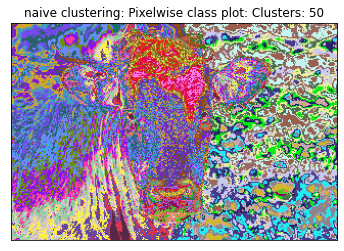

In [ ]:
gvb

You will make some adjustments to your k-means clustering. After reflection, you will then implement a better superpixel algorithm: SLIC, which lets you generate superpixel maps like the following:

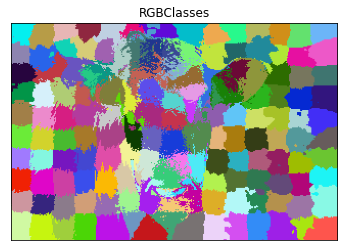

## Data

First, we download the MSRC labeled imaged database.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2021-10-12 11:33:22--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.84.168.111, 2600:1407:3c00:10a2::e59, 2600:1407:3c00:108c::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.84.168.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M   157MB/s    in 0.3s    

2021-10-12 11:33:22 (157 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



For this assignment, we will only use the following images. We define the list below as `im_list`.

In [ ]:

im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.





In [ ]:
#All important functions to plot
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import math

def plot_image(im,title,xticks=[],yticks= [],isCv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}
    
    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return    

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust} 
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot: 
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the 
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

For example, the following code uses `plot_image` to plot the 6 images we are using for this assignment.

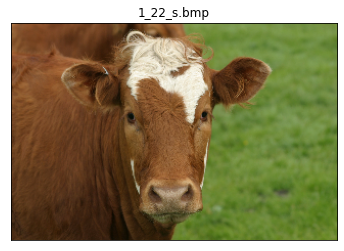

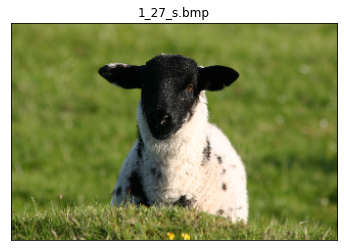

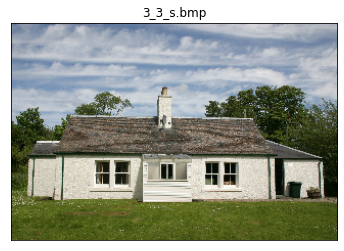

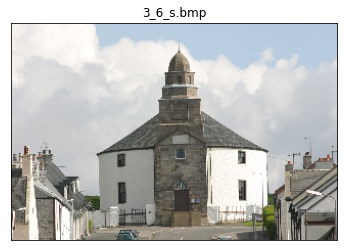

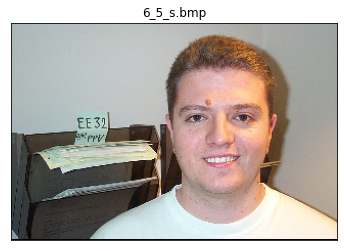

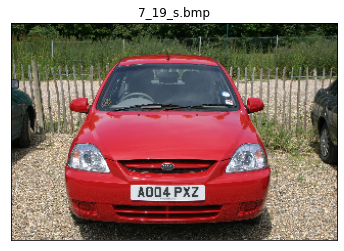

In [ ]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

## Part 1: K-means on Image Pixels

For this portion of the assignment, you will attempt to identify superpixels by using k-means with various attributes of the image's pixels as inputs (r, g, b, and/or x, y).

### Question 1: Perform k-means on image pixels `(r, g, b)`. (20 points)
 
The k-means clustering algorithm is an unsupervised algorithm which, for some items and for some specified number of clusters represented by cluster centers, minimizes the distance between items and their associated cluster centers. It does so by iteratively assigning items to a cluster and recomputing the cluster center based on the assigned items.

Complete the pixel clustering function. It should take input an image (shape = `(n, m, 3)`) and number of clusters. Each pixel should be represented by a vector with 3 values: `(r, g, b)`.

Then, let our provided code plot the pixelwise and superpixel plots for the cow image (`1_22_s.bmp`), using your `cluster_pixels` implementation with the provided values for the number of clusters: `5, 10, 50`.




In [ ]:
class Cluster:
    def __init__(self, rgb_vec, xy_vec):
        self.rgb_vec = rgb_vec
        self.xy_vec = xy_vec
        self.cluster_center = np.append(rgb_vec, xy_vec)
        self.points = []

        
class Pixel:
    def __init__(self, rgb, xy):
        self.rgb = rgb
        self.xy = xy

In [ ]:
#Assigns pixels to the nearest XLUSTER
def nearest_cluster(im, pixel, cluster_vecs, lambda1, lambda2):
    min_dist = math.inf
    min_pix_dist= 0
    pix_vec = np.append(pixel.rgb, pixel.xy)

    pix_dist = cluster_vecs - pix_vec 
    
    rgb_dist = np.linalg.norm(pix_dist[:, :3], axis=1) 
    xy_dist = np.linalg.norm(pix_dist[:, 3:], axis=1)


    rgb_dist = lambda1*rgb_dist
    xy_dist = lambda2*xy_dist

    total_dist = (rgb_dist + xy_dist)
    min_pix_dist = np.argmin(total_dist)
    return min_pix_dist

#Creates the segmentation map of the different cluster
def cluster_assign(img, seg_map, clusters, cluster_vecs, lambda1, lambda2):
    h = im.shape[0]
    w = im.shape[1]
    for i in range(h):
        for j in range(w):
            pix_rgb = im[i,j]
            pix = Pixel(pix_rgb, np.array([i,j]))
            
            closest_cluster = nearest_cluster(img, pix, cluster_vecs, lambda1, lambda2)
            pix_vec = np.append(pix_rgb, [i,j])
            clusters[closest_cluster].points.append(pix_vec)
            
            seg_map[i,j] = closest_cluster + 1

    return clusters,cluster_vecs

#Initialize Cluster Centers           
def initial_centroids(img, num_centroids):
    clusters = []
    cluster_vecs = []
    for i in range(num_centroids):
        point = (np.random.randint(0, im.shape[0]), np.random.randint(0, im.shape[1]))
        pixel = img[point]
        #print('pixel',pixel)
        cluster = Cluster(pixel, np.array(point))
        clusters.append(cluster)
        cluster_vecs.append(np.append(pixel, point))

    return clusters, np.array(cluster_vecs)

#Adjusting Cluster Centers
def adjust_cluster_centroids(clusters, cluster_vecs):
    clusters1=[]
    for i, cluster in enumerate(clusters):
        #print(i)
        points = cluster.points
        #print('points',points)
        if len(points) > 0:
            mean_val = np.mean(points, axis=0)
            #print('mean',mean_val)
            cluster.rgb_vec = mean_val[:3]
            cluster.xy_vec = mean_val[3:] 
            cluster.cluster_center = mean_val
            clusters1.append(cluster)    
            #print('center',clusters1)    
            cluster_vecs[i] = mean_val  
            cluster.points = []
        else:
            mean_val = [0,0,0,0,0]
            #print('mean',mean_val)
            cluster.rgb_vec = mean_val[:3]
            cluster.xy_vec = mean_val[3:] 
            cluster.cluster_center = mean_val
            clusters1.append(cluster)    
            #print('center',clusters1)    
            cluster_vecs[i] = mean_val  
            cluster.points = []

    return clusters1,cluster_vecs

#Function to check if K-means has converged
def convergence_check(new_cluster_centroids, prev_cluster_centroids, min_diff=3):
    #print(len(new_cluster_centroids),len(prev_cluster_centroids))
    if len(new_cluster_centroids) == 0 or len(prev_cluster_centroids) == 0 or len(new_cluster_centroids)!=len(prev_cluster_centroids):
        return False 

    new_cluster_centroids = np.array(new_cluster_centroids)
    prev_cluster_centroids = np.array(prev_cluster_centroids)
    diff = np.linalg.norm(new_cluster_centroids - prev_cluster_centroids, axis=1).sum()
    return diff <= min_diff

In [ ]:
#Function to run K-means and adjust cluster centroid for a specific number of iterations
def kmeans(img, k, rgb, xy, lambda1, lambda2, num_iteration=10):
    
    new_cluster_centroids = []
    prev_cluster_centroids = []
    seg_map = -1 * np.ones((img.shape[0], img.shape[1]))
    
    clusters, cluster_vecs = initial_centroids(img, num_centroids=k)
    itr = 0
    while itr < num_iteration and not convergence_check(new_cluster_centroids, prev_cluster_centroids) :
        prev_cluster_centroids=[cluster.cluster_center for cluster in clusters]
        #print('prev',prev_cluster_centroids)
        
        clusters,cluster_vecs=cluster_assign(img, seg_map, clusters, cluster_vecs, lambda1, lambda2)

        clusters,cluster_vecs=adjust_cluster_centroids(clusters, cluster_vecs)

        new_cluster_centroids=[cluster.cluster_center for cluster in clusters]
        #print('new',len(new_cluster_centroids))
        itr += 1
        print('Clusters: ', k, ': Iteration: ', itr)
        
    return seg_map

Clusters:  5 : Iteration:  1
Clusters:  5 : Iteration:  2
Clusters:  5 : Iteration:  3
Clusters:  5 : Iteration:  4
Clusters:  5 : Iteration:  5
Clusters:  5 : Iteration:  6
Clusters:  5 : Iteration:  7
Clusters:  5 : Iteration:  8
Clusters:  5 : Iteration:  9
Clusters:  5 : Iteration:  10
Clusters:  10 : Iteration:  1
Clusters:  10 : Iteration:  2
Clusters:  10 : Iteration:  3
Clusters:  10 : Iteration:  4
Clusters:  10 : Iteration:  5
Clusters:  10 : Iteration:  6
Clusters:  10 : Iteration:  7
Clusters:  10 : Iteration:  8
Clusters:  10 : Iteration:  9
Clusters:  10 : Iteration:  10
Clusters:  50 : Iteration:  1
Clusters:  50 : Iteration:  2
Clusters:  50 : Iteration:  3
Clusters:  50 : Iteration:  4
Clusters:  50 : Iteration:  5
Clusters:  50 : Iteration:  6
Clusters:  50 : Iteration:  7
Clusters:  50 : Iteration:  8
Clusters:  50 : Iteration:  9
Clusters:  50 : Iteration:  10
Clusters:  5 : Iteration:  1
Clusters:  5 : Iteration:  2
Clusters:  5 : Iteration:  3
Clusters:  5 : Itera

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Clusters:  50 : Iteration:  1
Clusters:  50 : Iteration:  2
Clusters:  50 : Iteration:  3
Clusters:  50 : Iteration:  4
Clusters:  50 : Iteration:  5
Clusters:  50 : Iteration:  6
Clusters:  50 : Iteration:  7
Clusters:  50 : Iteration:  8
Clusters:  50 : Iteration:  9
Clusters:  50 : Iteration:  10
Clusters:  5 : Iteration:  1
Clusters:  5 : Iteration:  2
Clusters:  5 : Iteration:  3
Clusters:  5 : Iteration:  4
Clusters:  5 : Iteration:  5
Clusters:  5 : Iteration:  6
Clusters:  5 : Iteration:  7
Clusters:  5 : Iteration:  8
Clusters:  5 : Iteration:  9
Clusters:  5 : Iteration:  10
Clusters:  10 : Iteration:  1
Clusters:  10 : Iteration:  2
Clusters:  10 : Iteration:  3
Clusters:  10 : Iteration:  4
Clusters:  10 : Iteration:  5
Clusters:  10 : Iteration:  6
Clusters:  10 : Iteration:  7
Clusters:  10 : Iteration:  8
Clusters:  10 : Iteration:  9
Clusters:  10 : Iteration:  10
Clusters:  50 : Iteration:  1
Clusters:  50 : Iteration:  2
Clusters:  50 : Iteration:  3
Clusters:  50 : I

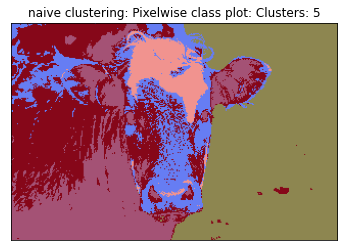

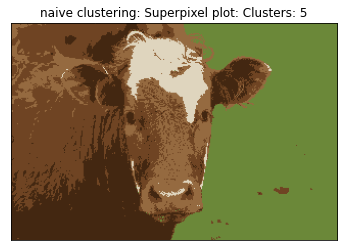

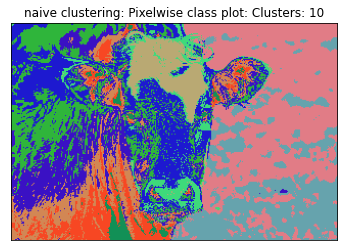

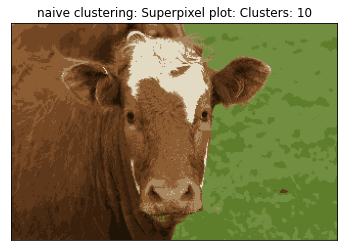

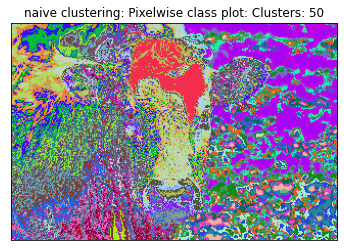

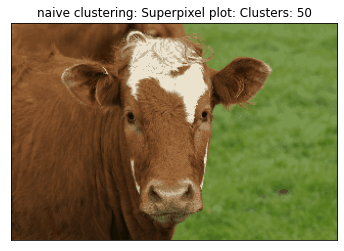

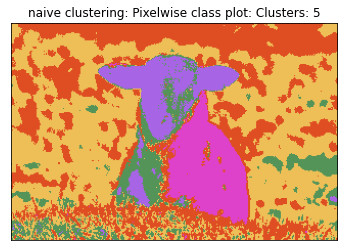

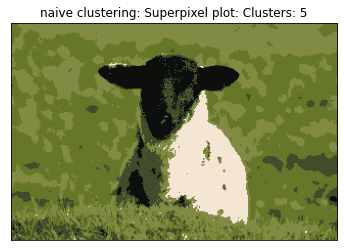

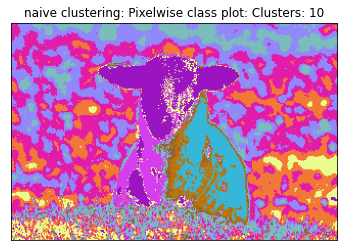

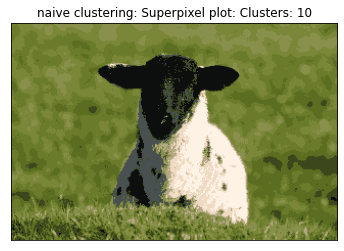

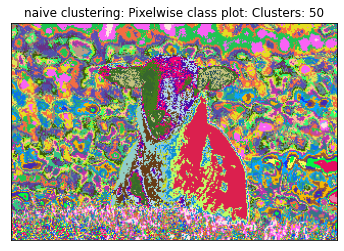

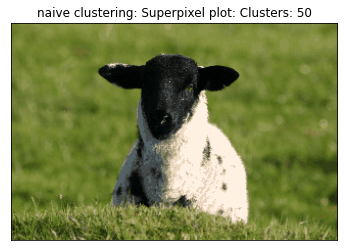

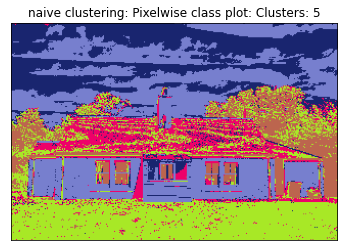

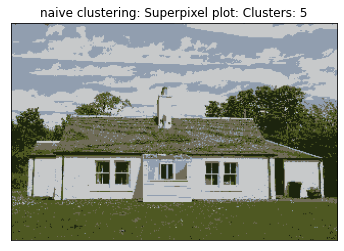

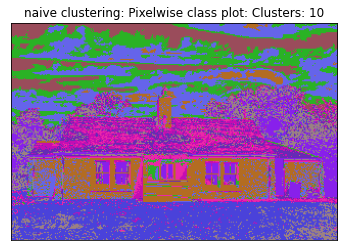

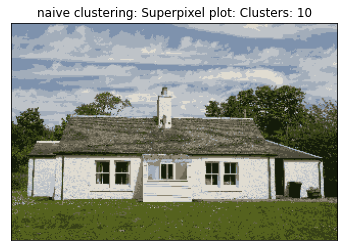

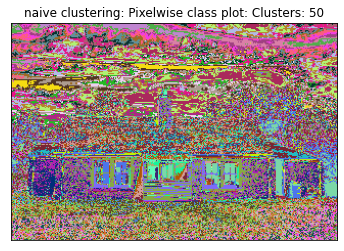

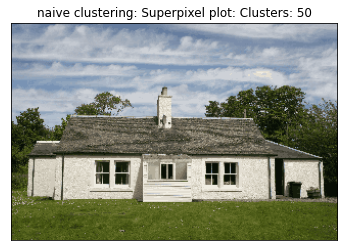

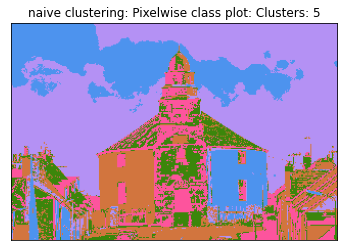

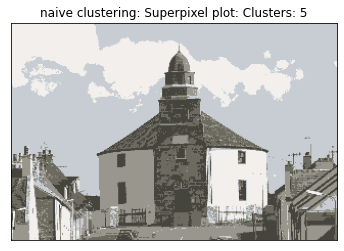

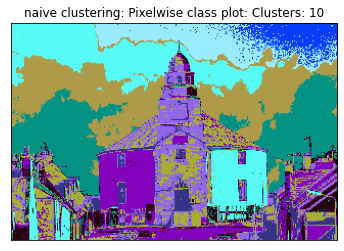

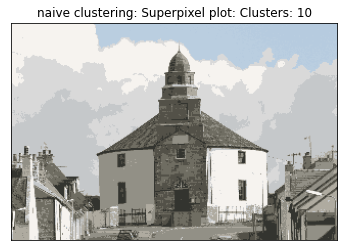

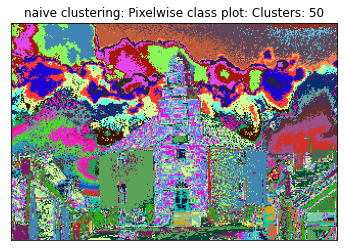

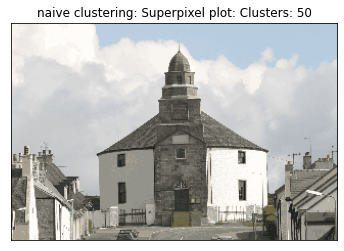

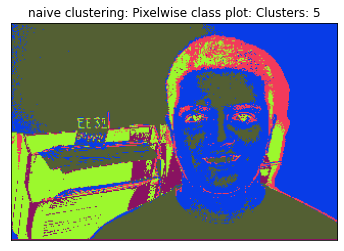

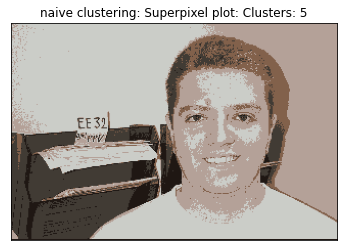

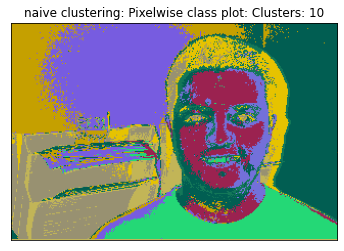

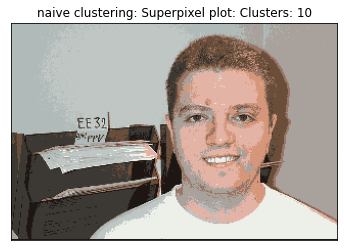

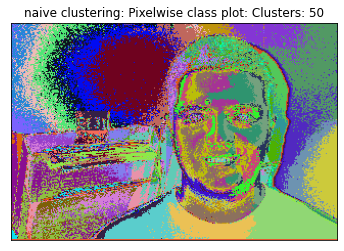

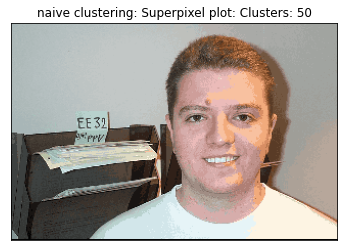

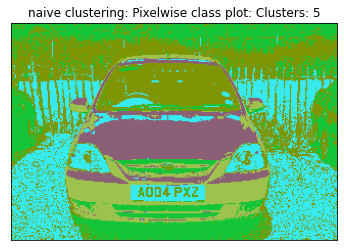

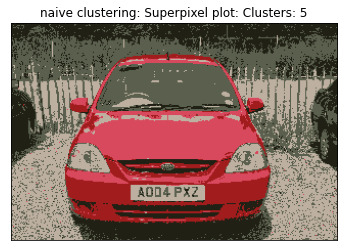

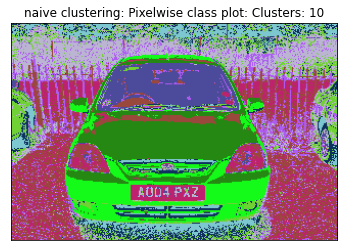

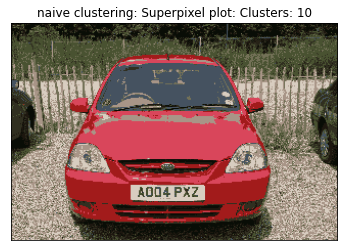

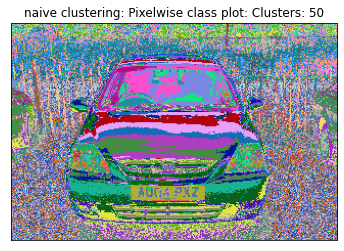

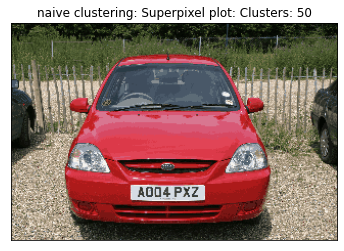

In [ ]:
from sklearn.cluster import KMeans
import numpy as  np

def cluster_pixels(im,k):    
    #TODO Pixelwise clustering   
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel

    #Clustering based on (r,g,b) values alone
    rgb=True
    xy=False
    segmap = kmeans(im, k, rgb, xy,lambda1=1,lambda2=0)
    return segmap
c=0
for img in im_list:
  if c>=0:
    im = cv2.imread(img)
    for k in [5,10,50]:
        clusters = cluster_pixels(im,k)
        #print(clusters)
        _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
        superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))



### Question 2: Perform k-means on image pixels `(r, g, b, x, y)`. (10 points)

Instead of the clustering running on (r,g,b) values, run the clustering on (r,b,g,x,y).

Try with clusters = `5,10,25,50,150`. You only need to plot the cow (`1_22_s.bmp`).
____

Clusters:  5 : Iteration:  1
Clusters:  5 : Iteration:  2
Clusters:  5 : Iteration:  3
Clusters:  5 : Iteration:  4
Clusters:  5 : Iteration:  5
Clusters:  5 : Iteration:  6
Clusters:  5 : Iteration:  7
Clusters:  5 : Iteration:  8
Clusters:  5 : Iteration:  9
Clusters:  5 : Iteration:  10
Clusters:  10 : Iteration:  1
Clusters:  10 : Iteration:  2
Clusters:  10 : Iteration:  3
Clusters:  10 : Iteration:  4
Clusters:  10 : Iteration:  5
Clusters:  10 : Iteration:  6
Clusters:  10 : Iteration:  7
Clusters:  10 : Iteration:  8
Clusters:  10 : Iteration:  9
Clusters:  10 : Iteration:  10
Clusters:  25 : Iteration:  1
Clusters:  25 : Iteration:  2
Clusters:  25 : Iteration:  3
Clusters:  25 : Iteration:  4
Clusters:  25 : Iteration:  5
Clusters:  25 : Iteration:  6
Clusters:  25 : Iteration:  7
Clusters:  25 : Iteration:  8
Clusters:  25 : Iteration:  9
Clusters:  25 : Iteration:  10
Clusters:  50 : Iteration:  1
Clusters:  50 : Iteration:  2
Clusters:  50 : Iteration:  3
Clusters:  50 : I

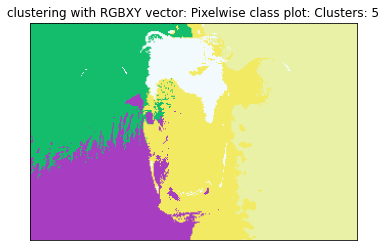

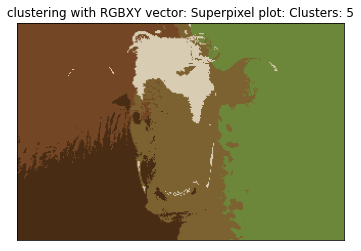

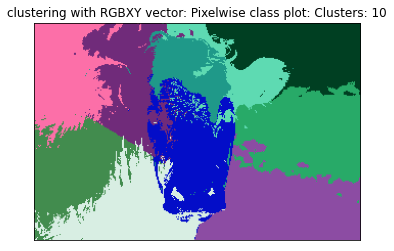

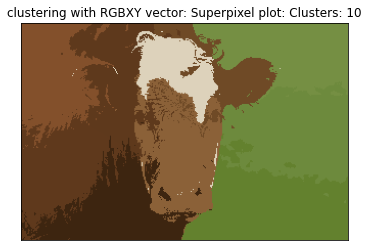

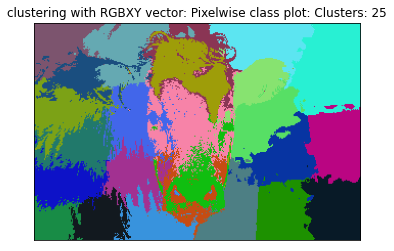

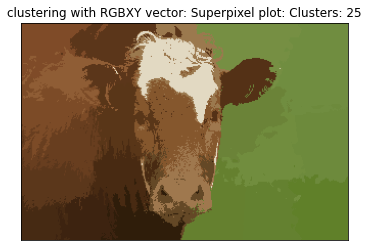

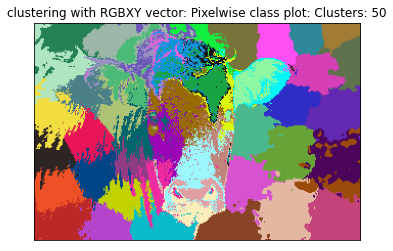

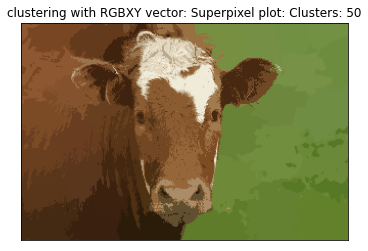

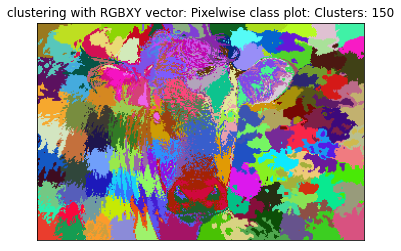

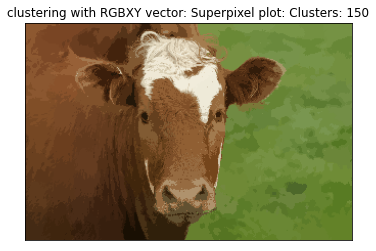

In [ ]:
#TODO: clustering r,b,g,x,y values 
#try k = 20,80,200,400,800

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    #assert 1==2,"NOT IMPLEMENTED"
    # giving equal weight to the position of the pixels too 

    #Clustering based on both (r,g,b) and (x,y) 
    rgb=True
    xy=True
    segmap = kmeans(im, k, rgb,xy,lambda1=1,lambda2=1)
    return segmap

im = cv2.imread(im_list[0])
for k in [5,10,25,50,150]:
    clusters = cluster_rgbxy(im,k)
    
    _ = rgb_segment(clusters,n = k, title =  "clustering with RGBXY vector: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "clustering with RGBXY vector: Superpixel plot: Clusters: "+ str(k))



### Question 3: What advantage did the `(r, g, b, x, y)` clustering give, compared to `(r, g, b)`? Please answer in 3 sentences or fewer. (5 points)

Your Answer:

* Using 5 dimensions groups similar pixels better than using just (r,g,b) due to the grouping based on the pixel intetnsity at a particular position.
* The cluster centers are computed based on (r,g,b,x,y) thus leading to similar pixels merging together to form superpixels of better quality.
* The grouped pixels are more compact, have uniform size and adhere to the object boundaries.


### Question 4: K-means on image pixels `(r, g, b, x, y)` with weighted distances. (15 points)

 Let: $cluster\_center_i$ be $i^{th}$ cluster center. $cluster\_center_i^{rgb}$ be the rgb value and $cluster\_center_i^{xy}$ be the corresponding coordinate of the pixel.
 
 Let $x_{rgb}$ be the the rgb value of a point
 Let $x_{xy}$ be the coordinate of $x_{rgb}$

Use the following distance function for k-means: $distance(x_{rgb},x_{xy}) = \lambda_1 * euclidean(x_{rgb},cluster\_center_{i}^{rgb})  + \lambda_2 * euclidean(x_{xy},cluster\_center_{i}^{xy})$

Find good values for $\lambda_1$ and $\lambda_2$ for 250 clusters.

With those good values, **plot results for all 6 images in `im_list`.**

Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clust

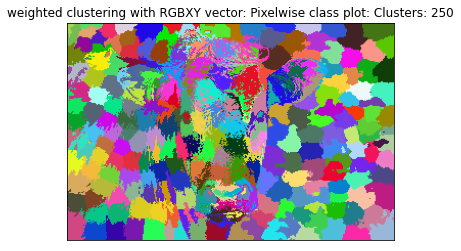

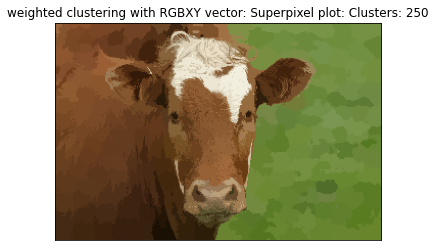

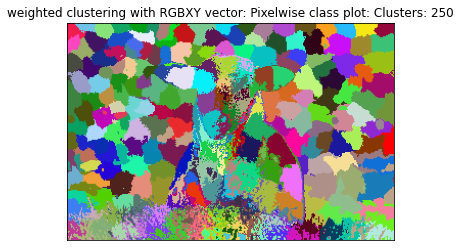

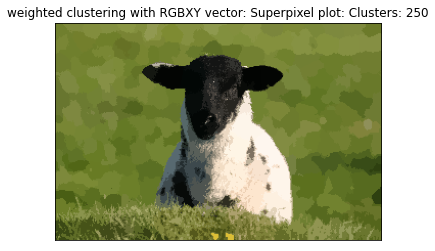

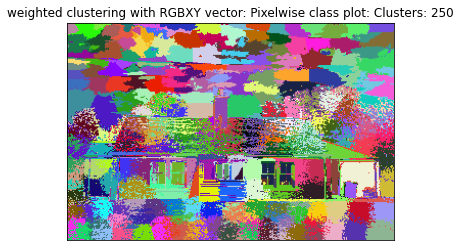

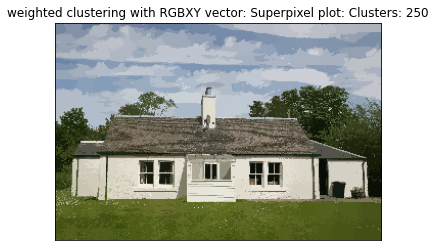

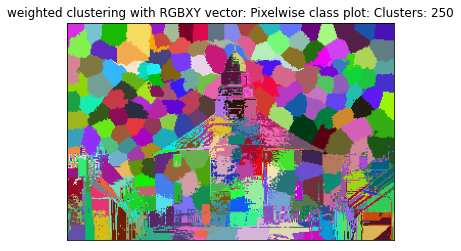

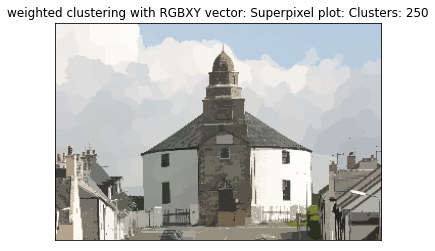

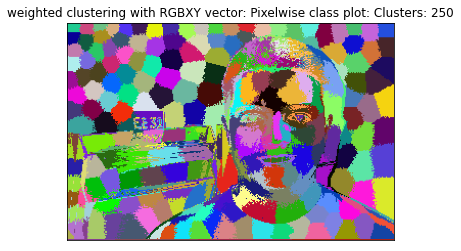

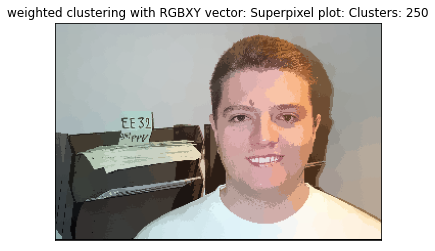

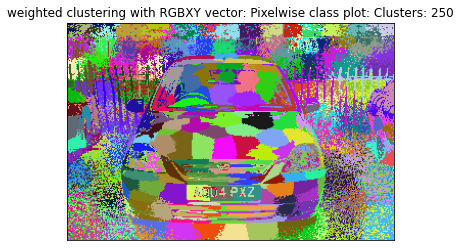

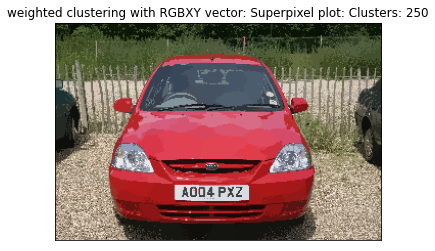

In [ ]:
#TODO: clustering r,b,g,x,y values with lambdas and display outputs
def cluster_rgbxy_with_weights(im,k, lambda_1, lambda_2):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    #assert 1==2,"NOT IMPLEMENTED"

    #Clustering based on (r,g,b) and (x,y) with weighted distances lambda1 and lambda2
    rgb=True
    xy=True
    segmap = kmeans(im, k, rgb, xy, lambda_1, lambda_2)
    return segmap


for i, im_name in enumerate(im_list):
  im = cv2.imread(im_name)
  k = 250
  clusters = cluster_rgbxy_with_weights(im, k=250, lambda_1=20, lambda_2=40)
  _ = rgb_segment(clusters,n = k, title =  "weighted clustering with RGBXY vector: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(im,clusters,title =  "weighted clustering with RGBXY vector: Superpixel plot: Clusters: "+ str(k))



### Question 5: Replicate SLIC (50 points)

It doesn't look like we have a very favourable outcome with superpixels simply being implemented. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.

**Finding an existing implementation of SLIC and using it for your assigment would be considered cheating.**

In [ ]:
#Function to compute the distance measure in 5D space. 
def euclidean_distance(p1,p2,rgb,xy,heuristic):
    d_lab=np.linalg.norm(p1.rgb-p2.rgb)
    d_xy=np.linalg.norm(p1.xy-p2.xy)

    d_s = d_lab +  heuristic * d_xy

    return d_s

#Function to Initialize the superpixel cluster centers
def init_clusters(img, h, w, k, S):
    cluster_list = []

    for i in range(S//2, h, S):
        for j in range(S//2, w, S):
            pix = img[i,j]
            cluster = Cluster(pix, np.array([i,j]))

            #Lowest gradients
            compute_gradient(img, h, w, cluster)
            
            cluster_list.append(cluster)
            
    return cluster_list

#Function to compute the lowest gradient in a 3x3 neighborhood
def compute_gradient(img, h, w, cluster):
    pos_y, pos_x = cluster.xy_vec
    color_val = cluster.rgb_vec
    min_grad = math.inf
    for i in range(pos_y-1, pos_y+2):
        for j in range(pos_x-1, pos_x+2):
            #print(i,j)
            i, j = validate_point(h, w, i, j)
                
            gradient = calc_gradient(img, j, i)
            
            if gradient < min_grad:
                min_grad = gradient
                cluster.xy_vec = np.array([i, j])
                cluster.rgb_vec = img[i, j]


def validate_point(h, w, y, x):
    if y < 0:
        y = 0 
    elif y >= h:
        y = h - 1
    if x < 0:
        x = 0 
    elif x >= w:
        x = w - 1
    
    return y, x
            
def calc_gradient(img, x, y):
    vec1 = img[y+1, x] - img[y-1, x]
    vec2 = img[y, x+1] - img[y, x-1]
    gradient = (np.linalg.norm(vec1)**2 + np.linalg.norm(vec2)**2)
    return gradient

#Function to assign pixels to superpixel clusters in a 2s x 2s neighborhood
def assign_pixels_to_clusters(im, h, w, clusters, m, S, distance_map, seg_map):
    for c_ind, cluster in enumerate(clusters):
        pos_y, pos_x = cluster.xy_vec
        pos_y, pos_x = int(pos_y), int(pos_x)
        for i in range(pos_y-S, pos_y+S):
            for j in range(pos_x-S, pos_x+S):
                
                i, j = validate_point(h, w, i, j)
                
                pix = im[i,j]
                curr_pixel = Pixel(pix, np.array([i,j]))

                centroid = Pixel(cluster.rgb_vec, cluster.xy_vec)
                #Using m=10 and (m/S) to be multiplies with the normalized xy plane distance to obtain the total distance measure
                dist = euclidean_distance(curr_pixel, centroid, rgb=True,xy=True, heuristic=(m/S))

                if dist < distance_map[i,j]:
                    distance_map[i,j] = dist
                    #print(c_ind)
                    seg_map[i,j] = c_ind + 1

def adjust_cluster_centers(img, clusters, seg_map, pos_map):
    for ind, cluster in enumerate(clusters):
        match = (seg_map == (ind+1))
        
        pix_lab = img[match]
        pix_yx = pos_map[match]
        
        rgb_mean = pix_lab.mean(axis=0)
        xy_mean = pix_yx.mean(axis=0)
        
        cluster.color_center = rgb_mean
        cluster.xy_center = xy_mean


In [ ]:
import skimage.color
def slic_seg(img, k,m, num_iter):
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float64)
    img=skimage.color.rgb2lab(img)
    MAX_NUM = math.inf
    h, w = img.shape[0], img.shape[1]
    
    seg_map = -1 * np.ones((h, w))
    distance_map =  MAX_NUM * np.ones((h, w))
    pos_map = []
    for i in range(h):
      pos_list = []
      for j in range(w):
          pos_list.append([i,j])
      pos_map.append(pos_list)
    pos_map = np.array(pos_map)
    
    N = img.shape[0]*img.shape[1]  # total_num_pixels
    S = int(math.sqrt(N/k))
    
    #Initialize Cluster centers in a 3X3 neighborhood
    clusters = init_clusters(img, h, w, k, S)
    
    itr = 0
    while itr < num_iter:
        assign_pixels_to_clusters(img, h, w, clusters, m, S, distance_map, seg_map)
        
        adjust_cluster_centers(img, clusters, seg_map, pos_map)
        
        itr += 1
        print('Clusters: ', k, ': Iteration: ', itr)
        
        # repeat
    
    return seg_map

In [ ]:
def SLIC(im, k):
    """
    Input arguments: 
    img: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..
    
    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    segmap = slic_seg(im, k, m=10, num_iter=10)
    return segmap


With SLIC implemented, plot results for all 6 images.

Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clusters:  250 : Iteration:  3
Clusters:  250 : Iteration:  4
Clusters:  250 : Iteration:  5
Clusters:  250 : Iteration:  6
Clusters:  250 : Iteration:  7
Clusters:  250 : Iteration:  8
Clusters:  250 : Iteration:  9
Clusters:  250 : Iteration:  10
Clusters:  250 : Iteration:  1
Clusters:  250 : Iteration:  2
Clust

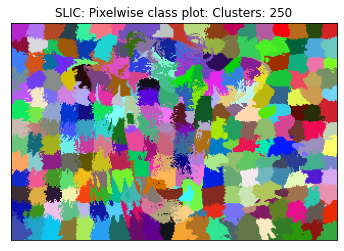

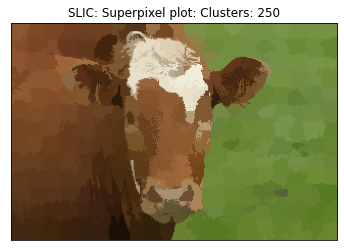

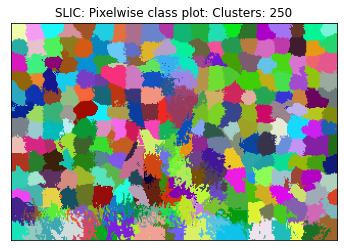

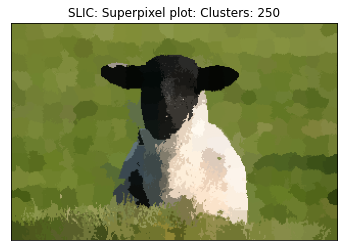

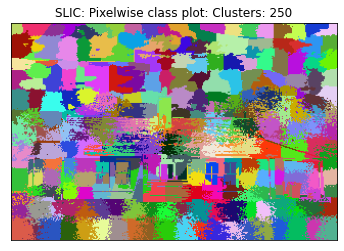

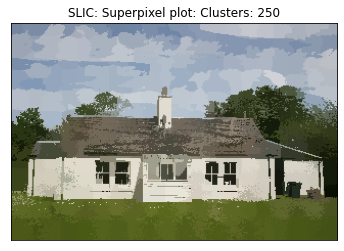

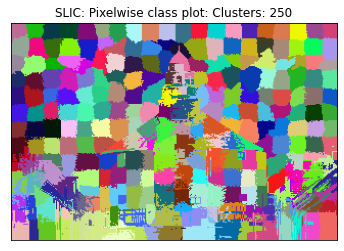

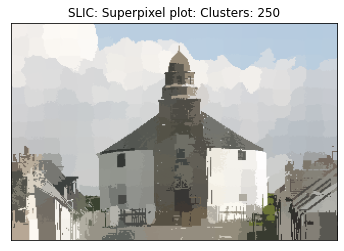

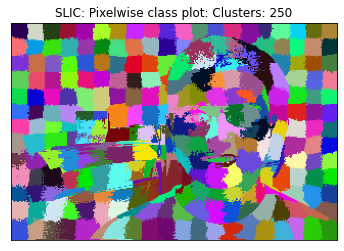

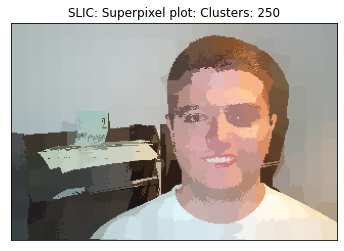

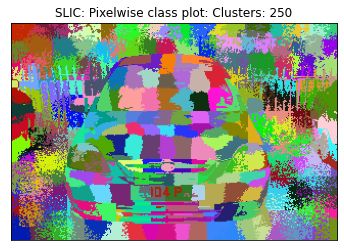

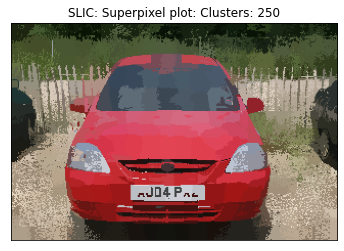

In [ ]:
## TODO: Call our plot functions with your SLIC results for all 6 images
k=250
for i, img in enumerate(im_list):
  img = cv2.imread(img)
  clusters = SLIC(img, k) 
  _ = rgb_segment(clusters,n = k, title =  "SLIC: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(img,clusters,title =  "SLIC: Superpixel plot: Clusters: "+ str(k))


### Bonus Question: Enforce connectivity (20 points)
There are many superpixels which are very small and disconnected from each other. Merge them with larger superpixels

O(N) algorithm:
1. Set minimum size of superpixel
2. If region smaller than threshold, assign to nearest cluster 

Plot results for the 6 images.
